# QPE

This program simulates a quantum circuit for binary addition using the quantum Fourier transform using Qiskit. \
Author: Michal Forgó \
Time: 02.14.2025 \
Note: Ensure you have installed the requirements.txt or environment.yml before running this notebook.

Bitstring: 11110011000010101110, Count: 93441, Estimated phi: 2pi*0.9493846893310547, probability: 0.9344
Bitstring: 01001111001001000001, Count: 2100, Estimated phi: 2pi*0.3091440200805664, probability: 0.0210
Bitstring: 10100011100011000100, Count: 1668, Estimated phi: 2pi*0.6388587951660156, probability: 0.0167
Bitstring: 10100011100011000011, Count: 1411, Estimated phi: 2pi*0.6388578414916992, probability: 0.0141
Bitstring: 01001111001001000000, Count: 211, Estimated phi: 2pi*0.30914306640625, probability: 0.0021
Bitstring: 10110001101101001010, Count: 191, Estimated phi: 2pi*0.6941623687744141, probability: 0.0019
Bitstring: 10100011100011000010, Count: 168, Estimated phi: 2pi*0.6388568878173828, probability: 0.0017
Bitstring: 10100011100011000101, Count: 140, Estimated phi: 2pi*0.638859748840332, probability: 0.0014
Bitstring: 01001111001001000010, Count: 84, Estimated phi: 2pi*0.3091449737548828, probability: 0.0008
Bitstring: 10100011100011000110, Count: 68, Estimated phi: 2pi*

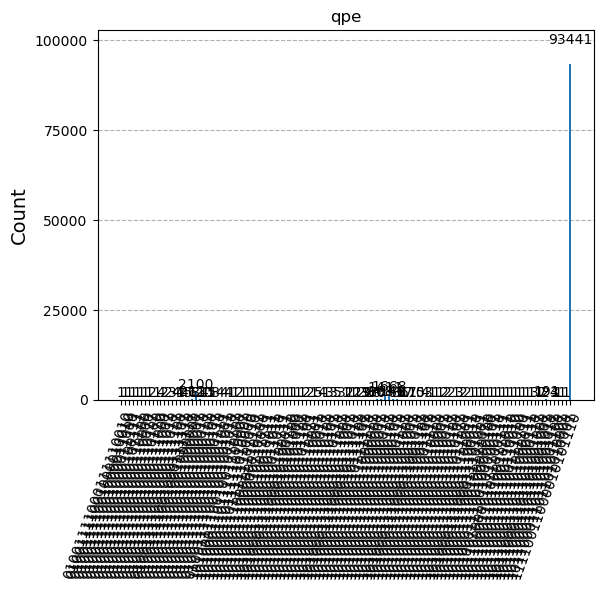

In [ ]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import QFT, UnitaryGate, StatePreparation
from qiskit_aer import AerSimulator
import scipy.linalg as la
from qiskit.visualization import plot_histogram

# Example usage:
A = np.array([
    [2, 1+1j, 0, 7-1j],
    [1-1j, 3, 2j, 0],
    [0, -2j, 1, 1],
    [7+1j, 0, 1, 4]
])
vec = np.array([-0.24153492+0.14716025j,  0.0263928 -0.54296084j,  0.7764049 +0.j,
                 -0.13751656+0.05278559j]) # Example vector b, needs to match the dimension of A, can be any complex vector
vec = vec / np.linalg.norm(vec)  # Normalize the vector


n_count = 20   # Number of counting qubits
shots = 100_000



# Check dimension is a power of 2
n = A.shape[0]
if not (n & (n - 1) == 0) and n != 0:
    raise ValueError("Matrix dimension must be a power of 2.")

# Number of qubits for the target (log2 of dimension)
n_qubits = int(np.log2(n))

# Compute U = exp(iAt)
t = 1 
iA = t*1j * A
U = la.expm(iA)

# Create Qiskit UnitaryGate for U
gate = UnitaryGate(U, label="exp(iA)")

# Build QPE circuit
qc = QuantumCircuit(n_count + n_qubits, n_count)

# Prepare counting qubits in |+>
qc.h(range(n_count))

# Prepare target register in |1>^⊗n_qubits (simple approach: apply X to all target qubits)
# Example vector b
prep = StatePreparation(vec)
qc.append(prep, [i for i in range(n_count, n_count + n_qubits)])
qc.draw('mpl')




# Controlled-U^(2^j) applications
for j in range(n_count):
    # Compute power of U
    powered = gate.power(2**j)
    # Controlled version, control is counting qubit j, targets are the n_qubits starting from n_count
    c_power = powered.control(1)
    qc.append(c_power, [j] + list(range(n_count, n_count + n_qubits)))

# Apply inverse QFT on counting register
qc.append(QFT(n_count, inverse=True, name="QFT†"), range(n_count))

# Measure counting qubits
qc.measure(range(n_count), range(n_count))
qc.draw(output='mpl', filename='qpe_circuit.png')

# Simulate
simulator = AerSimulator(shots=shots)
compiled = transpile(qc, simulator)
job = simulator.run(compiled)
result = job.result()

counts = result.get_counts(compiled)


# Plot histogram (can be commented out if running in non-graphical environment)
k = 10  # number of most likely phases you want

sorted_counts = sorted(counts.items(), key=lambda item: item[1], reverse=True)
top_k = sorted_counts[:k]

for bitstring, count in top_k:
    estimated_phi = int(bitstring, 2) / 2**n_count
    print(f"Bitstring: {bitstring}, Count: {count}, Estimated phi: 2pi*{estimated_phi**(1/t)}, probability: {(count/shots):.4f}")


plot_histogram(counts, title=f"qpe")





In [110]:


# Calculate eigenvalues and eigenvectors
eigvals, eigvecs = np.linalg.eig(A)
eigvals_U, eigvecs_U = np.linalg.eig(U)

#print(f"Eigenvalue: {eigvals}")
print(f"Phase: 2pi*{np.angle(eigvals_U)/(2 * np.pi)%1}")
print(f"Eigenvector (as np.array):\n{eigvecs}")


Phase: 2pi*[0.30914379 0.94938469 0.63885834 0.69416261]
Eigenvector (as np.array):
[[ 0.64797866-0.09007165j  0.74746365+0.j         -0.08681946-0.03164524j
   0.00886733+0.06849219j]
 [ 0.08124446-0.08415731j -0.10846765+0.07713841j  0.03570337-0.52353887j
   0.83260653+0.j        ]
 [ 0.06196666-0.01747709j  0.09060385-0.02438662j  0.84097052+0.j
  -0.02981243-0.52813892j]
 [ 0.74443423+0.j         -0.63817184-0.0866918j  -0.06134276+0.07140674j
  -0.10021605-0.11015353j]]
